<a href="https://colab.research.google.com/github/halldm2000/NOAA-AI-2020-TUTORIAL/blob/master/curve_fit_wind_vs_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Packages**

In [ ]:
!pip install netCDF4

**Download Data**

In [ ]:
import os
source = "https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc"
dest    = "data/ibtracs/"
!wget -c -e robots=off -P {dest} {source}

--2020-10-08 20:58:03--  https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.ALL.v04r00.nc
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.178, 205.167.25.171, 205.167.25.172, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.178|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



**Load Data**

In [ ]:
import xarray as xr

# read data from file
ds   = xr.open_dataset("/content/data/ibtracs/IBTrACS.ALL.v04r00.nc")
wind = ds['usa_wind'].data
pres = ds['usa_pres'].data

# find indices where both variables are valid
wind_valid = ~np.isnan(wind)
pres_valid = ~np.isnan(pres)
valid      = np.logical_and(pres_valid,wind_valid)

# keep only valid data
wind = wind[valid]
pres = pres[valid]

**Plot Data**

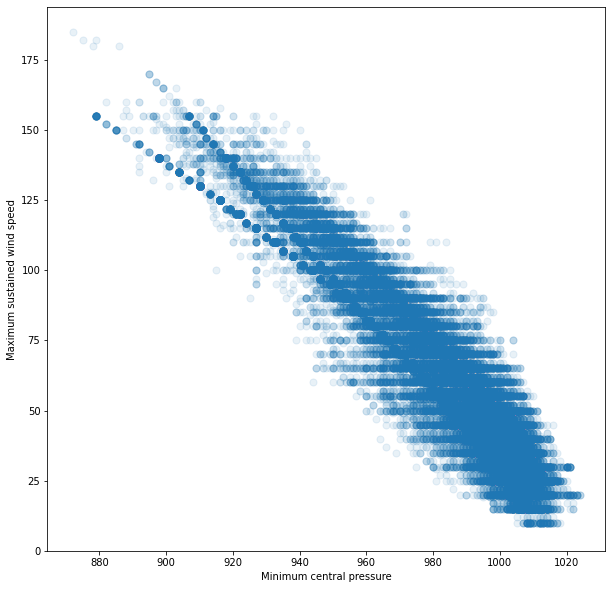

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.scatter(pres,wind,s=50,alpha=0.1)
plt.xlabel(ds['usa_pres'].long_name)
plt.ylabel(ds['usa_wind'].long_name);
plt.ylim(bottom=0);

In [ ]:
def plot(input,pred):
  plt.figure(figsize=(10,5))
  plt.scatter(pres,wind,s=50,alpha=0.1)
  plt.xlabel(ds['usa_pres'].long_name)
  plt.ylabel(ds['usa_wind'].long_name);

  x = xscaler.inverse_transform(input)
  y = yscaler.inverse_transform(pred)

  plt.scatter(x,y,color='orange',s=5)
  plt.show()


cpu
torch.Size([134751, 1])
epoch=0 training loss=0.13739174604415894


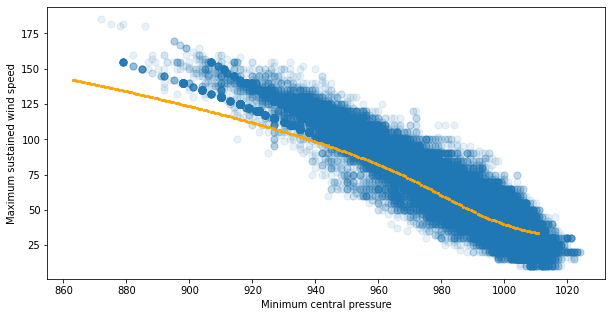

epoch=1 training loss=0.1066492423415184


KeyboardInterrupt: ignored

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch, torch.nn as nn, torch.optim as optim, torch.utils.data as data
from sklearn.preprocessing import StandardScaler

# GPU 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# DATA

# reshape data to (nsamples, nvars)
x = pres.reshape(-1,1)
y = wind.reshape(-1,1)

# normalize data
xscaler = StandardScaler()
X = xscaler.fit_transform(x)

yscaler = StandardScaler()
Y = yscaler.fit_transform(y)
X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)

train_dataset = data.TensorDataset(X, Y)
train_loader  = data.DataLoader(train_dataset, batch_size=10000, shuffle=True, num_workers=0)

# MODEL

N = 10
model = nn.Sequential(
    nn.Linear(1  ,N), nn.ELU(),
    nn.Linear(N,N), nn.ELU(),
    nn.Linear(N,1  )
)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-1)
loss_fcn  = nn.MSELoss()

# TRAIN

model.train()
for epoch in range(10):

  for i, data in enumerate(train_loader):

    input, target = data[0].to(device), data[1].to(device)# move data to GPU

    # get model prediction
    prediction = model(input)
    
    # improve the prediction a little
    optimizer.zero_grad()
    train_loss = loss_fcn(prediction,target)
    train_loss.backward()
    optimizer.step()

  with torch.no_grad():

    print(f"epoch={epoch} training loss={train_loss.item()}")#,end="\r")

    domain = torch.linspace(-6,1,200).view(-1,1)
    pred = model(domain)
    plot(domain.numpy(), pred.numpy())
